In [3]:
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
from sklearn.model_selection import train_test_split

In [4]:
# =============================================================================
# 1. Data Preprocessing Function
# =============================================================================
def preprocess_data(df):
    # Create an occupancy column from lights.
    df['Occupancy'] = df['lights'].apply(lambda x: 1 if x > 0 else 0)
    
    # Compute average indoor temperature from columns T1 to T9.
    temp_cols = [f'T{i}' for i in range(1, 10)]
    df['Avg_T1_T9'] = df[temp_cols].mean(axis=1)
    
    # Compute HVAC energy as Appliances minus lights.
    df['HVAC_energy'] = df['Appliances'] - df['lights']
    
    # Extract hour from the date column.
    df['date'] = pd.to_datetime(df['date'])
    df['Hour_of_day'] = df['date'].dt.hour
    
    # Only keep relevant features.
    relevant_features = ['Avg_T1_T9', 'T_out', 'Occupancy', 'Hour_of_day', 'HVAC_energy']
    df = df[relevant_features].copy()
    df.ffill(inplace=True)
    return df

In [5]:
# =============================================================================
# 2. HVAC Environment (Dynamic Temperature, Scaled Reward)
# =============================================================================
class HVACEnvironment:
    def __init__(self, dataframe, desired_temperature=22):
        self.df = dataframe.copy()
        self.desired_temperature = desired_temperature
        self.observation_space_shape = self.df.shape[1]  # number of features
        self.action_space_n = 4  # 0=Off, 1=Low, 2=Medium, 3=High
        self.current_step = 0
        self.max_steps = len(self.df) - 1
        
        # (For simulation purposes.)
        self.energy_thresholds = {
            'Low': self.df['HVAC_energy'].quantile(0.25),
            'Medium': self.df['HVAC_energy'].quantile(0.5),
            'High': self.df['HVAC_energy'].quantile(0.75)
        }
        # Initialize the mutable indoor temperature.
        self.current_temp = self.df['Avg_T1_T9'].iloc[0]
        
    def reset(self, start_step=0):
        self.current_step = start_step
        self.current_temp = self.df['Avg_T1_T9'].iloc[self.current_step]
        return self._get_state()
    
    def _get_state(self):
        # Return state vector where the indoor temperature is updated.
        row = self.df.iloc[self.current_step].copy()
        row['Avg_T1_T9'] = self.current_temp
        return row.values
    
    def _get_reward(self, action, simulated_energy):
        # Scale down the reward for numerical stability.
        lambda_factor = 1
        reward = -(simulated_energy + lambda_factor * abs(self.current_temp - self.desired_temperature)) / 1000.0
        return reward
    
    def _take_action(self, action):
        if action == 0:
            return np.random.uniform(0, 25)
        elif action == 1:
            return np.random.uniform(25, 100)
        elif action == 2:
            return np.random.uniform(100, 300)
        elif action == 3:
            return np.random.uniform(300, 500)
        else:
            raise ValueError("Invalid action.")
    
    def step(self, action):
        simulated_energy = self._take_action(action)
        # Update indoor temperature: a simple dynamic approaching the desired temperature.
        temp_change = (self.desired_temperature - self.current_temp) * 0.05
        self.current_temp += temp_change * (simulated_energy / 500.0)
        
        self.current_step += 1
        next_state = self._get_state()
        reward = self._get_reward(action, simulated_energy)
        done = self.current_step >= self.max_steps
        return next_state, reward, done, {"HVAC_energy": simulated_energy}


In [6]:
# =============================================================================
# 3. Double DQN Model Components
# =============================================================================
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
    
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # Convert list of tuples into tuple of arrays.
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

In [7]:
# =============================================================================
# 4. DDQN Agent
# =============================================================================
class DDQNAgent:
    def __init__(self, state_size, action_size, device):
        self.state_size = state_size
        self.action_size = action_size
        self.device = device
        
        # Hyperparameters
        self.gamma = 0.99
        self.epsilon = 1.0       # Starting exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 1e-5
        self.batch_size = 64
        self.update_target_every = 5
        
        # Networks
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.target_network = QNetwork(state_size, action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        
        self.memory = ReplayBuffer(capacity=10000)
        self.steps_done = 0
    
    def act(self, state):
        # Epsilon-greedy action selection.
        if random.random() < self.epsilon:
            return random.randrange(self.action_size)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)
        return int(torch.argmax(q_values, dim=1).item())
    
    def store(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
    
    def learn(self):
        if len(self.memory) < self.batch_size:
            return None
        
        # Sample a batch of transitions.
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        # Convert lists to numpy arrays then to tensors.
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(np.array(actions)).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(np.array(dones).astype(np.uint8)).unsqueeze(1).to(self.device)
        
        # Compute Q-values for current states.
        q_values = self.q_network(states).gather(1, actions)
        
        # Double DQN target: select action from online network, and evaluate using target.
        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(dim=1, keepdim=True)
            next_q_values = self.target_network(next_states).gather(1, next_actions)
            target_values = rewards + self.gamma * next_q_values * (1 - dones)
        
        loss = nn.MSELoss()(q_values, target_values)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [8]:
# =============================================================================
# 5. Training Function for DDQN with Loss Monitoring
# =============================================================================
def train_ddqn(env, agent, n_episodes=1000, max_t=500, cost_factor=0.10):
    episode_rewards = []     # List for total reward per episode
    episode_losses = []      # List for average loss per episode
    train_metrics = []       # List for detailed dict metrics per episode
    overall_start_time = time.time()
    
    for episode in range(n_episodes):
        ep_start_time = time.time()
        state = env.reset()
        total_reward = 0.0
        t = 0
        
        # For evaluation metrics.
        baseline_energy_sum = 0.0
        rl_energy_sum = 0.0
        temp_deviation_sum = 0.0
        
        losses = []  # Accumulate losses during this episode
        
        for t in range(max_t):
            baseline_energy_sum += state[-1]
            temp_deviation_sum += abs(state[0] - env.desired_temperature)
            
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            rl_energy_sum += info.get("HVAC_energy", 0.0)
            
            # Store transition in the replay buffer.
            agent.store(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state
            
            # Perform learning update and record loss.
            loss = agent.learn()
            if loss is not None:
                losses.append(loss)
            
            if done:
                break
        
        ep_end_time = time.time()  # End time for this episode
        ep_duration = ep_end_time - ep_start_time
        
        agent.decay_epsilon()
        if episode % agent.update_target_every == 0:
            agent.update_target_network()
        
        avg_loss = np.mean(losses) if losses else 0.0
        energy_savings = baseline_energy_sum - rl_energy_sum
        avg_temp_deviation = temp_deviation_sum / (t + 1)
        cost_savings = energy_savings * cost_factor
        
        print(f"Episode {episode+1:3d} | Steps: {t+1:4d} | Total Reward: {total_reward:9.2f} | "
              f"Avg Loss: {avg_loss:8.4f} | Epsilon: {agent.epsilon:6.3f} | Time: {ep_duration:6.2f} sec")
        print(f"    Energy Savings (Wh): {energy_savings:8.2f} | Temp Deviation: {avg_temp_deviation:6.2f} | "
              f"Cost Savings ($): {cost_savings:6.2f}")
        
        episode_rewards.append(total_reward)
        episode_losses.append(avg_loss)
        train_metrics.append({
            "episode": episode+1,
            "steps": t+1,
            "total_reward": total_reward,
            "avg_loss": avg_loss,
            "epsilon": agent.epsilon,
            "energy_savings": energy_savings,
            "avg_temp_deviation": avg_temp_deviation,
            "cost_savings": cost_savings,
            "episode_time": ep_duration
        })
    
    overall_end_time = time.time()  # Cumulative training end time
    total_training_time = overall_end_time - overall_start_time
    print(f"Total training time: {total_training_time:.2f} seconds")
        
    return episode_rewards, episode_losses, train_metrics


In [9]:
# =============================================================================
# 6. Evaluation Function for DDQN 
# =============================================================================
def evaluate_ddqn(env, agent, n_episodes=50, max_t=500, C_energy=0.10):
    results = []
    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0.0
        t = 0
        baseline_energy_sum = 0.0
        rl_energy_sum = 0.0
        temp_deviation_sum = 0.0
        
        done = False
        while not done and t < max_t:
            baseline_energy_sum += state[-1]
            temp_deviation_sum += abs(state[0] - env.desired_temperature)
            action = agent.act(state)
            state, reward, done, info = env.step(action)
            rl_energy_sum += info.get("HVAC_energy", 0.0)
            total_reward += reward
            t += 1
        
        energy_savings = baseline_energy_sum - rl_energy_sum
        avg_temp_deviation = temp_deviation_sum / (t+1) if t > 0 else 0.0
        cost_savings = energy_savings * C_energy
        
        print(f"Eval Episode {episode+1:3d} | Steps: {t:4d} | Total Reward: {total_reward:9.2f}")
        print(f"    Energy Savings (Wh): {energy_savings:8.2f} | Temp Deviation: {avg_temp_deviation:6.2f} | "
              f"Cost Savings ($): {cost_savings:6.2f}")
        print("--------------------------------------------------------------")
        
        results.append({
            "episode": episode+1,
            "steps": t,
            "total_reward": total_reward,
            "energy_savings": energy_savings,
            "avg_temp_deviation": avg_temp_deviation,
            "cost_savings": cost_savings
        })
        
    avg_reward = np.mean([r["total_reward"] for r in results])
    avg_energy_savings = np.mean([r["energy_savings"] for r in results])
    avg_temp_deviation = np.mean([r["avg_temp_deviation"] for r in results])
    avg_cost_savings = np.mean([r["cost_savings"] for r in results])
    
    print("\nFinal Average Evaluation Metrics over all evaluation episodes:")
    print(f"Avg Total Reward: {avg_reward:.2f}")
    print(f"Avg Energy Savings (Wh): {avg_energy_savings:.2f}")
    print(f"Avg Temperature Deviation: {avg_temp_deviation:.2f}")
    print(f"Avg Cost Savings ($): {avg_cost_savings:.2f}")
    
    return results


In [10]:
# =============================================================================
# 7. Plotting Functions for Training and Evaluation Metrics
# =============================================================================
def plot_training_results(train_metrics, train_losses):
    # Extract episode numbers and total rewards from the train_metrics dictionaries
    episodes = [m['episode'] for m in train_metrics]
    total_rewards = [m['total_reward'] for m in train_metrics]
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(episodes, total_rewards, marker='o', label="Total Reward")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Total Reward vs Episode")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(episodes, train_losses, marker='o', color='red', label="Avg Loss")
    plt.xlabel("Episode")
    plt.ylabel("Avg Loss")
    plt.title("Training Loss vs Episode")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_evaluation_results(eval_results):
    episodes = [res["episode"] for res in eval_results]
    total_rewards = [res["total_reward"] for res in eval_results]
    energy_savings = [res["energy_savings"] for res in eval_results]
    temp_deviations = [res["avg_temp_deviation"] for res in eval_results]
    cost_savings = [res["cost_savings"] for res in eval_results]
    
    plt.figure(figsize=(14,10))
    
    plt.subplot(2,2,1)
    plt.plot(episodes, total_rewards, marker='o', label='Total Reward')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Evaluation Total Reward vs Episode")
    plt.legend()
    
    plt.subplot(2,2,2)
    plt.plot(episodes, energy_savings, marker='o', color='green', label='Energy Savings (Wh)')
    plt.xlabel("Episode")
    plt.ylabel("Energy Savings (Wh)")
    plt.title("Energy Savings vs Episode")
    plt.legend()
    
    plt.subplot(2,2,3)
    plt.plot(episodes, temp_deviations, marker='o', color='orange', label='Temp Deviation')
    plt.xlabel("Episode")
    plt.ylabel("Avg Temp Deviation")
    plt.title("Temperature Deviation vs Episode")
    plt.legend()
    
    plt.subplot(2,2,4)
    plt.plot(episodes, cost_savings, marker='o', color='purple', label='Cost Savings ($)')
    plt.xlabel("Episode")
    plt.ylabel("Cost Savings ($)")
    plt.title("Cost Savings vs Episode")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Train samples: 13814
Test samples: 2960
Validation samples: 2961

Starting training on training split...
Episode   1 | Steps:  500 | Total Reward:    -85.03 | Avg Loss:  16.0304 | Epsilon:  0.995 | Time:  87.04 sec
    Energy Savings (Wh): -36124.24 | Temp Deviation:   0.43 | Cost Savings ($): -3612.42
Episode   2 | Steps:  500 | Total Reward:    -89.10 | Avg Loss:   1.7250 | Epsilon:  0.990 | Time: 103.70 sec
    Energy Savings (Wh): -40189.10 | Temp Deviation:   0.43 | Cost Savings ($): -4018.91
Episode   3 | Steps:  500 | Total Reward:    -85.88 | Avg Loss:   1.0982 | Epsilon:  0.985 | Time: 106.94 sec
    Energy Savings (Wh): -36912.62 | Temp Deviation:   0.55 | Cost Savings ($): -3691.26
Episode   4 | Steps:  500 | Total Reward:    -81.13 | Avg Loss:   0.9186 | Epsilon:  0.980 | Time: 106.12 sec
    Energy Savings (Wh): -32212.23 | Temp Deviation:   0.44 | Cost Savings ($): -3221.22
Episode   5 | Steps:  500 | Total Reward:    -85.45 | Avg Loss:   1.0332 | Epsilon:  0.975 | Time: 

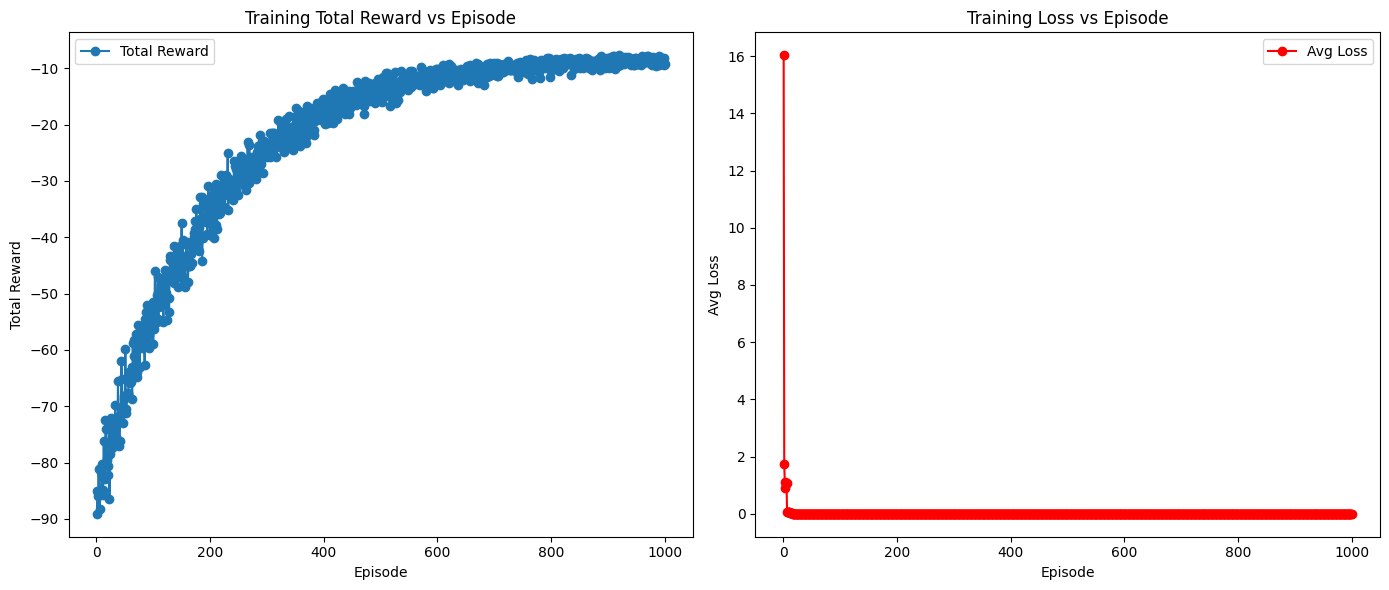

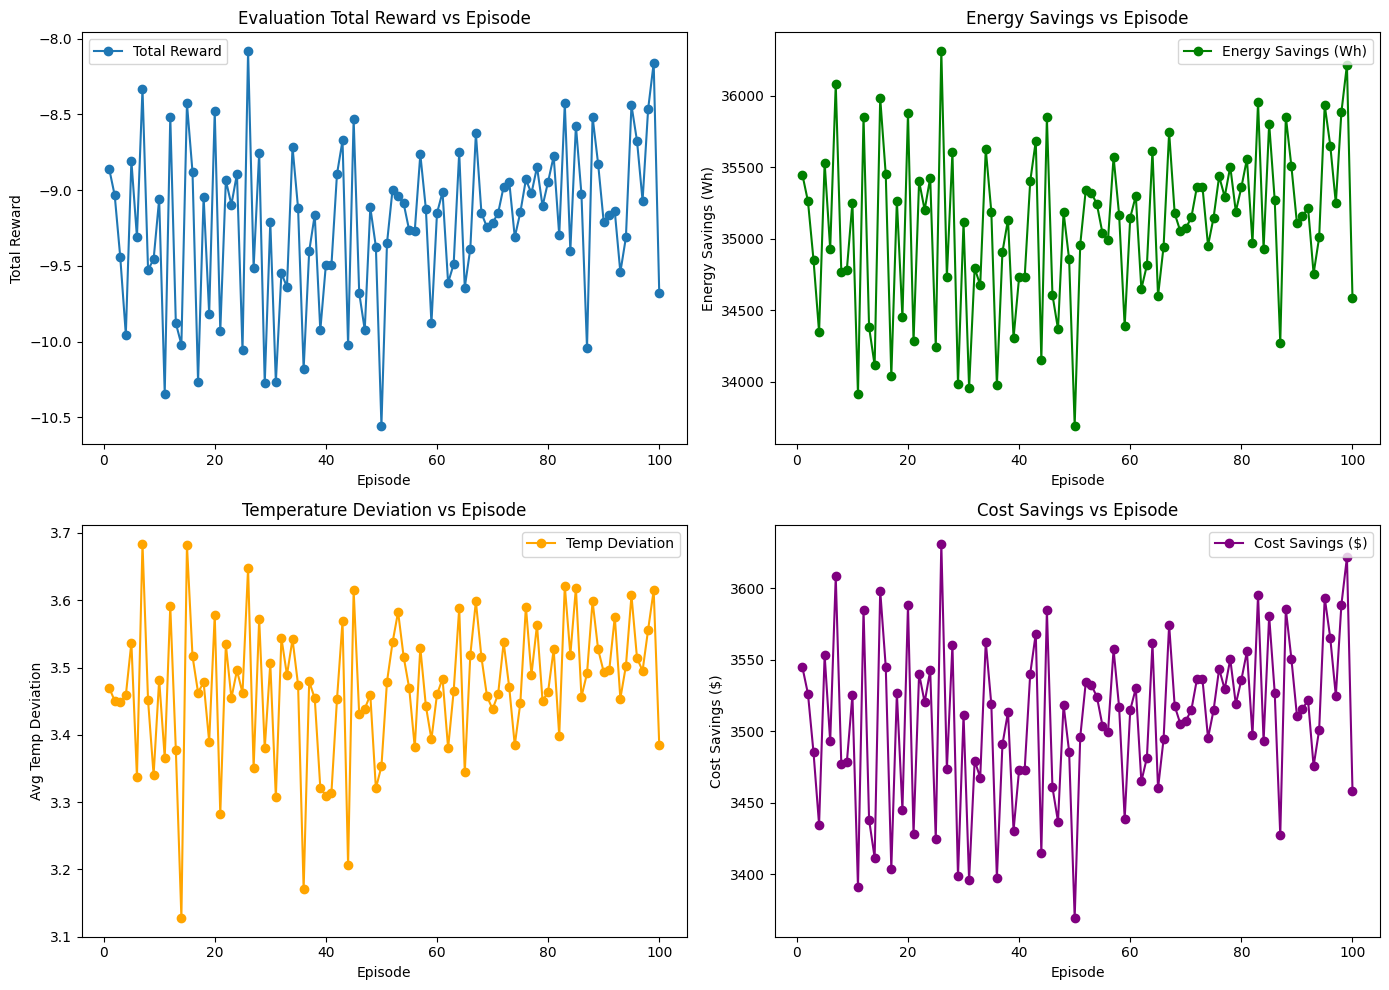

In [11]:
# =============================================================================
# 8. Main Execution
# =============================================================================
if __name__ == "__main__":
    # ------------- Load and Preprocess the Data -------------
    df = pd.read_csv("raw_data.csv")
    df = preprocess_data(df)
    
    # ------------- Data Split: 70% Train, 15% Test, 15% Validation -------------
    train_data, temp_data = train_test_split(df, test_size=0.30, random_state=42)
    test_data, val_data = train_test_split(temp_data, test_size=0.50, random_state=42)
    
    print(f"Train samples: {len(train_data)}")
    print(f"Test samples: {len(test_data)}")
    print(f"Validation samples: {len(val_data)}")
    
    # ------------- Create Environments for Each Data Split -------------
    env_train = HVACEnvironment(train_data, desired_temperature=22)
    env_test  = HVACEnvironment(test_data, desired_temperature=22)
    env_val   = HVACEnvironment(val_data, desired_temperature=22)
    
    # ------------- Initialize the DDQN Agent -------------
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state_size = env_train.observation_space_shape
    action_size = env_train.action_space_n
    agent = DDQNAgent(state_size, action_size, device)
    
    # ------------- Train the Agent on the Training Split -------------
    print("\nStarting training on training split...")
    episode_rewards, episode_losses, train_metrics = train_ddqn(env_train, agent, n_episodes=1000, max_t=500)
    
    # ------------- Evaluate the Trained Model -------------
    print("\nEvaluating on test split:")
    test_results = evaluate_ddqn(env_test, agent, n_episodes=100, max_t=500, C_energy=0.10)
    
    print("\nEvaluating on validation split:")
    val_results = evaluate_ddqn(env_val, agent, n_episodes=100, max_t=500, C_energy=0.10)
    
    # ------------- Plot the Metrics -------------
    plot_training_results(train_metrics, episode_losses)
    plot_evaluation_results(test_results)